In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms

In [20]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device) My laptop uses cpu
torch.manual_seed(2023)

#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(), 
                transforms.Normalize((0.1307,), (0.3081,))   
                ]),
#    transform = ToTensor(), 
    download = True,            
)
random_label = torch.tensor(np.random.randint(0, 10, (len(train_data))))
train_data.targets = random_label

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(), 
                transforms.Normalize((0.1307,), (0.3081,))   
                ]),
)

loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = 100,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = 100,
                                            shuffle=True
                                            )
}

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(32 * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x   # return x for visualization

In [22]:
def train(model, optimizer, train_loader, loss_func):
    model.train()
    correct = 0
    train_loss = 0
    counter = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        counter += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        correct += np.equal(pred, target.data).sum()
    
    train_loss = (train_loss * 100) / len(train_loader.dataset)
    acc = 100.0 * correct / len(train_loader.dataset)
    return train_loss, acc

In [23]:
def test(model, epoch, test_loader, loss_func):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        loss = loss_func(output, target)
        test_loss += loss.data

        pred = np.argmax(output.data, axis = 1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss = (test_loss * 100) / len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [26]:
model = CNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
m1_train_loss_arr = []
m1_test_loss_arr = []

epochs = 50
log_interval = 500
loss_func = torch.nn.CrossEntropyLoss()
for epoch in range(1, epochs + 1):
    tr_loss, acc = train(model, optimizer, loaders['train'], loss_func)
    m1_train_loss_arr.append(tr_loss)
    loss_test = test(model, epoch, loaders['test'], loss_func)
    m1_test_loss_arr.append(loss_test)
    print('Epoch: ', epoch)
    print('Loss= ', tr_loss)


Test set, Epoch 1 , Average loss: 2.3056, Accuracy: 985/10000 (10%)

Epoch:  1
Loss=  tensor(2.3036)

Test set, Epoch 2 , Average loss: 2.3090, Accuracy: 478/10000 (5%)

Epoch:  2
Loss=  tensor(2.3024)

Test set, Epoch 3 , Average loss: 2.3042, Accuracy: 1219/10000 (12%)

Epoch:  3
Loss=  tensor(2.3019)

Test set, Epoch 4 , Average loss: 2.3073, Accuracy: 753/10000 (8%)

Epoch:  4
Loss=  tensor(2.3013)

Test set, Epoch 5 , Average loss: 2.3021, Accuracy: 1030/10000 (10%)

Epoch:  5
Loss=  tensor(2.3005)

Test set, Epoch 6 , Average loss: 2.3019, Accuracy: 945/10000 (9%)

Epoch:  6
Loss=  tensor(2.2996)

Test set, Epoch 7 , Average loss: 2.3082, Accuracy: 707/10000 (7%)

Epoch:  7
Loss=  tensor(2.2985)

Test set, Epoch 8 , Average loss: 2.3069, Accuracy: 980/10000 (10%)

Epoch:  8
Loss=  tensor(2.2971)

Test set, Epoch 9 , Average loss: 2.3005, Accuracy: 992/10000 (10%)

Epoch:  9
Loss=  tensor(2.2956)

Test set, Epoch 10 , Average loss: 2.3074, Accuracy: 1022/10000 (10%)

Epoch:  10
L

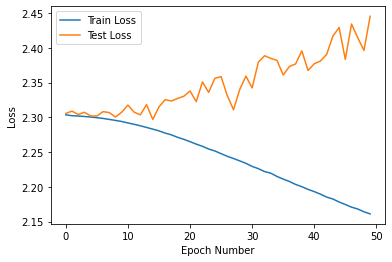

In [28]:
Train_loss = np.array(m1_train_loss_arr)
Test_loss = np.array(m1_test_loss_arr)
epoch = np.arange(0, 50, 1)
plt.plot(epoch, Train_loss, label = 'Train Loss')
plt.plot(epoch, Test_loss, label = 'Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()